<a href="https://colab.research.google.com/github/MQgeek9728/2020FallML/blob/master/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We first download some basic packages.

In [24]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Visualize the Data
First load data from 'https://raw.githubusercontent.com/yeb2Binfang/20MLproj/main/high_diamond_ranked_10min.csv'

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/yeb2Binfang/20MLproj/main/high_diamond_ranked_10min.csv')

In [26]:
df.head(6)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,0,0,15899,7.0,18161,225,42,698,101,22.5,1589.9,36,5,1,3,5,2,0,0,0,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1


In [27]:
df.shape

(9879, 40)

Save every column except for `gameId` and `blueWins` in a matrix as input samples X. Save `blueWins` column in a vector as output y.

In [28]:
#TODO
# Samples
xnames = df.columns[2:]
X = np.array(df[xnames])
# Target
y = np.array(df["blueWins"])

# Use .shape and print how many features and how many data entries are there
# save as nsamp, nfeatures
nsamp, nfea = X.shape
nout = y.shape
print('Number of samples = %d,  number of features = %d' % (nsamp,nfea))
print('Number of output = %d' % nout)


Number of samples = 9879,  number of features = 38
Number of output = 9879


Then split the data into training and test.  Use the `train_test_split` function with `test_size=0.25`. Save as Xtr, Xts, ytr, yts.


In [29]:
# Split the data into training and testing.
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.25) 
print(Xtr.shape)
print(ytr.shape)
print(Xts.shape)
print(yts.shape)

(7409, 38)
(7409,)
(2470, 38)
(2470,)


## Perform PCA for Visualization

Before performing PCA, we need to scale the data matrix to remove the mean and normalize the variance of the different components.  For this purpose, create a `StandardScaling` object `scaling`.  Then `fit` the scaling with the entire data `X`.  Transform the data and let `Xs` be the scaled data.

In [30]:
from sklearn.preprocessing import StandardScaler

# TODO
scaling = StandardScaler()
# Xs = scaling.fit(X)
scaling.fit(X)
Xs = scaling.transform(X)

Next, fit a PCA on the scaled data matrix Xs. Here we use the sklearn PCA method. Select svd_solver='randomized' and whiten=True. Use the the pca.transform method to find, Z, the coefficients of Xs in the PCA basis.

In [31]:
from sklearn.decomposition import PCA

# TODO
ncomp = 2

# Construct the PCA object
# pca = PCA(...)
pca = PCA(n_components=ncomp, 
          svd_solver='randomized', whiten=True)

# Fit the PCA components on the entire dataset
pca.fit(Xs)

# Find the coefficients of Xs in the PCA basis.
Z =  pca.transform(Xs)
Vtr = pca.components_  
Z.shape

(9879, 2)

In the transformed basis, each data sample is represented by a two dimensional vector, `Z[i,0], Z[i,1]`. Plot a scatter plot of the transformed data.

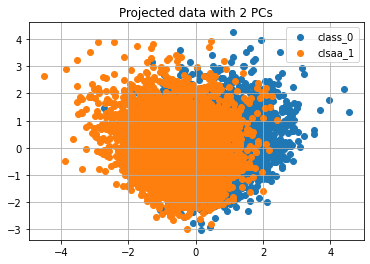

In [32]:
# TODO
# Note that for binary classification there are 2 classes. 
I0 = np.where(y==0)
I1 = np.where(y==1)
plt.scatter(Z[I0,0],Z[I0,1])
plt.scatter(Z[I1,0],Z[I1,1])
plt.legend(['class_0', 'clsaa_1'])
plt.title('Projected data with 2 PCs')
plt.grid()

## Using PCA with Classificaiton
We will now use data scaling and PCA as a pre-processing step for logistic classification.  The number of PCs to use can be found with cross-validation.  We will try different number of PCs components to use and measures the test accuracy for each value. Then we determine the optimal PCs to use with the highest test accuracy.

In [33]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
nfold = 5

# Create a K-fold object
kf = KFold(n_splits=nfold, shuffle=True)
kf.get_n_splits(X)

# Number of PCs to try
ncomp_test = np.arange(2,12)
num_nc = len(ncomp_test)

# Accuracy:  acc[icomp,ifold]  is test accuracy when using `ncomp = ncomp_test[icomp]` in fold `ifold`.
acc = np.zeros((num_nc,nfold))

# Loop over number of components to test
for icomp, ncomp in enumerate(ncomp_test):
    
    # Look over the folds
    for ifold, I in enumerate(kf.split(X)):
        Itr, Its = I

        # TODO:  Split data into training 
        Xtr = X[Itr]
        ytr = y[Itr]
        Xts = X[Its]
        yts = y[Its]

        # TODO:  Create a scaling object and fit the scaling on the training data
        scaling = StandardScaler()
        scaling.fit(Xtr)
        Xtrs = scaling.transform(Xtr)
        Xtss = scaling.transform(Xts)

        # TODO:  Fit the PCA on the scaled training data
        pca = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
        pca.fit(Xtrs)

        Ztr =  pca.transform(Xtrs)

        # TODO:  Train a classifier on the transformed training data
        # Use a logistic regression classifier
        logreg = LogisticRegression(multi_class='auto', solver='lbfgs')
        logreg.fit(Ztr, ytr)

        # TODO:  Transform the test data through data scaler and PCA    
        Zts = pca.transform(Xtss)

        # TODO:  Predict the labels the test data
        yhat = logreg.predict(Zts)
        
        # TODO:  Measure the accuracy 
        acc[icomp, ifold] = np.mean(yhat==yts)
        print('num_nc=%d nfold=%d acc=%12.4e' % (icomp+1, ifold, acc[icomp,ifold]) )



num_nc=1 nfold=0 acc=  7.2520e-01
num_nc=1 nfold=1 acc=  7.3178e-01
num_nc=1 nfold=2 acc=  7.2267e-01
num_nc=1 nfold=3 acc=  7.4241e-01
num_nc=1 nfold=4 acc=  7.2911e-01
num_nc=2 nfold=0 acc=  7.1711e-01
num_nc=2 nfold=1 acc=  7.1002e-01
num_nc=2 nfold=2 acc=  7.3178e-01
num_nc=2 nfold=3 acc=  7.3836e-01
num_nc=2 nfold=4 acc=  7.4025e-01
num_nc=3 nfold=0 acc=  7.3937e-01
num_nc=3 nfold=1 acc=  7.2166e-01
num_nc=3 nfold=2 acc=  7.2824e-01
num_nc=3 nfold=3 acc=  7.1356e-01
num_nc=3 nfold=4 acc=  7.3722e-01
num_nc=4 nfold=0 acc=  7.4494e-01
num_nc=4 nfold=1 acc=  7.3178e-01
num_nc=4 nfold=2 acc=  7.1154e-01
num_nc=4 nfold=3 acc=  7.2976e-01
num_nc=4 nfold=4 acc=  7.2405e-01
num_nc=5 nfold=0 acc=  7.1761e-01
num_nc=5 nfold=1 acc=  7.2773e-01
num_nc=5 nfold=2 acc=  7.2014e-01
num_nc=5 nfold=3 acc=  7.4798e-01
num_nc=5 nfold=4 acc=  7.3924e-01
num_nc=6 nfold=0 acc=  7.3178e-01
num_nc=6 nfold=1 acc=  7.3887e-01
num_nc=6 nfold=2 acc=  7.1913e-01
num_nc=6 nfold=3 acc=  7.3229e-01
num_nc=6 nfold

Use the plt.errorbar function to plot the mean accuracy with error bars corresponding to the standard error of the accuracy as a function of the number of components. Find the optimal number of PCs to use according to the normal rule and one SE rule, respectively.

The optimal order with the normal rule is 7
The best accuracy with the normal rule is 0.731653
The optimal order with one SE rule is 4
The best accuracy with the one SE rule is 0.728010


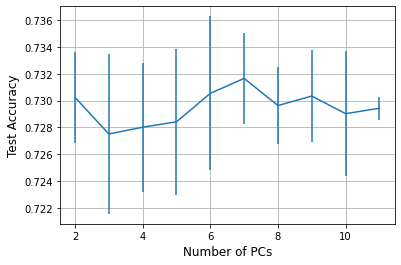

In [34]:
# TODO:
acc_mean = np.mean(acc, axis = 1)
acc_se = np.std(acc,axis=1)/np.sqrt(nfold-1)
plt.errorbar(ncomp_test, acc_mean, yerr=acc_se, fmt='-')
plt.xlabel('Number of PCs', fontsize = 12)
plt.ylabel('Test Accuracy', fontsize = 12)
plt.grid()

# TODO:  Optimal order with the normal rule
Iopt = np.argmax(acc_mean)
print("The optimal order with the normal rule is {0:d}".format(ncomp_test[Iopt]))
print("The best accuracy with the normal rule is {0:f}".format(acc_mean[Iopt]))

# TODO:  Optimal order with one SE rule
acc_tgt = acc_mean[Iopt] - acc_se[Iopt]

# Find the lowest PC order below the target
I = np.where(acc_mean <= acc_tgt)[0]
Iopt_se = I[len(I)-1]
print("The optimal order with one SE rule is %d" % ncomp_test[Iopt_se])
print("The best accuracy with the one SE rule is {0:f}" .format(acc_mean[Iopt_se]))

## SVM.svc model...